<a id='top_of_page'></a>
# GoodDoggo - Wrangling and Assessing 'WeRateDogs' Twitter Data

<a id='top_of_page'></a>
## Table of Contents

- **[Gather](#gather)**
  - [Retrieve Local Data (manually)](#retrieve_local)
  - [Retrieve Image Data from a url (programmatically](#retrieve_via_url)
  - [Retrieve Twitter Data (via API)](#retrieve_via_API)<br>

- **[Assess](#assess)**
  - [Quality](#assess_quality)
    - [Completeness](#assess_completeness)
    - [Validity](#assess_validity)
    - [Accuracy](#assess_accuracy)
    - [Consistency](#assess_consistency)
  - [Tidiness](#assess_tidiness)<br>
  - [Summary](#assess_summary)<br>

- **[Clean](#clean)**
  - [Quality](#clean_quality)
    - [Code Snippets - Merging Dataframes](#code_snippets_merging)
  - [Tidiness](#clean_tidiness)
  
- **[Open Items](#open_items)**
  - [To Check / Potentially Fix](#open_items_to_check)
    - [Accuracy of 'doggo' entries](#open_items_prelimCode_doggo_accuracy)
  - [To Be Aware of (don't necessarily have to fix)](#open_items_to_be_aware_of)

In [ ]:
# for data wrangling and sampling
import pandas as pd
import numpy as np
import random

import requests       # to download files programmatically
import os             # to save/open files and for terminal-like commands to navigate local machine
import tweepy
import pprint as pp   # data pretty printer - https://docs.python.org/2/library/pprint.html
import json           # for json I/O and parsing
import time           # for timing code and dealing with Twitter's rate limit

# Set the random seed to assure the same answers are returned each time 
random.seed(42)

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# for (potential) regression modeling of data
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

<a id='gather'></a>
([Top of Page](#top_of_page))
## Gather

<a id='retrieve_local'></a>
([Top of Page](#top_of_page))
### Retrieve Local Data (Read in a Previously Provided Twitter Archive)

In [23]:
df_archive = pd.read_csv("twitter-archive-enhanced.csv")
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='retrieve_via_url'></a>
([Top of Page](#top_of_page))
### Retrieve Image Data from a URL (programmatically)

In [24]:
# get file from a url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# get the current working directory
folder_name = os.getcwd()

# get the filename
file_name = url.split('/')[-1]

# save the retrieved file to local storage
with open(os.path.join(folder_name,
                      file_name), mode='wb') as file:
    file.write(response.content)

# read in the downloaded file
df_images = pd.read_csv(file_name, sep='\t')
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


NOTE:
* The response variable is in bytes format, not text format.
* As such, the 'wb' flag is used when writing the file locally
* [Link to a StackOverflow post](https://stackoverflow.com/questions/2665866/what-does-wb-mean-in-this-code-using-python) on the subject<br><br>

Template code for future reference:

In [ ]:
# template code to make a directory if it doesn't already exist
#folder_name = 'my_new_folder'
#if not os.path.exists(folder_name):
#    os.makedirs(folder_name)

# command to list the current directory's contents
#os.listdir()

<a id='retrieve_via_API'></a>
([Top of Page](#top_of_page))
### Retrieve Twitter Data (via API)

#### Create an API object to gather Twitter data

In [25]:
# get the API Access Token and Acces Token Secret
from twAPI_tokens_GoodDoggo import API_KEY, API_KEY_SECRET, API_TOKEN, API_TOKEN_SECRET

CONSUMER_KEY = API_KEY
CONSUMER_SECRET = API_KEY_SECRET
ACCESS_TOKEN = API_TOKEN
ACCESS_SECRET = API_TOKEN_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

# api = tweepy.API(auth)

# code snippet for getting around the twitter rate limit:
api = tweepy.API(auth, 
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

#### Get a list of tweet IDs:

In [26]:
# Check if there are any repeated tweets in the archive
numUniqueValues = df_archive.tweet_id.nunique()
print('Number of tweets: ' + str(len(df_archive)))
print('Number of repeated tweets: ' + str(len(df_archive) - numUniqueValues))

# Create list of tweet IDs
tweet_id_list = df_archive.tweet_id.tolist()

Number of tweets: 2356
Number of repeated tweets: 0


### Use the API to get info for each tweet

* ___Retrieve json data for the first tweet and write it to local storage___
* [StackOverflow article](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id) on getting JSON data for a specific tweet
* [StackAbuse article](https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/) on reading and writing JSON to a file in Python

In [104]:
print('- Tweet retrieval (for 2356 tweets) took 30 minutes to complete, due to Twitter\'s rate limit.\n' +
      '- As a result, it was performed once, then commented out to allow restarting the kernel / debugging\n' + 
      'the rest of the analysis.')

# loop through multiple tweet_id's, retrieving and writing their json data to 'tweet_json.txt' 
# with open('tweet_json.txt', mode = 'w') as textFile:
#     count = 0
#     for tweet_id in tweet_id_list:
#         count = count + 1
#         start = time.time()
#         try:
#             status = api.get_status(tweet_id)
#             jsonStr = json.dumps(status._json)
#         except:
#             continue     # tweet no longer exists
#         textFile.write(jsonStr + '\n')
#         end = time.time()
#         currTime = str(time.localtime().tm_hour) + ':' + str(time.localtime().tm_min) + ':' + str(time.localtime().tm_sec)
#         print('count: ' + str(count) + ', time elapsed: ' + str(end - start) + ', current time: ' + currTime)

- Tweet retrieval (for 2356 tweets) took 30 minutes to complete, due to Twitter's rate limit.
- As a result, it was performed once, then commented out to allow restarting the kernel / debugging
the rest of the analysis.


__Print first line of 'tweet_json.txt' to check that the above worked__

In [105]:
# print first line of 'tweet_json.txt' to check that the above worked
# with open('tweet_json.txt') as jsonFile:
#     line = jsonFile.readline()
#     tweet = json.loads(line)
#     pp.pprint(tweet)

**Add the tweet data to a dataframe**

In [106]:
# create a local dataframe for storing tweet data
df_tweetInfo = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])

# store tweet data to the dataframe
with open('tweet_json.txt') as jsonFile:
    count = 0
    start = time.time()
    for line in jsonFile:
        count = count + 1
        tweet = json.loads(line)
        df_tweetInfo = df_tweetInfo.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        }, ignore_index=True)
        end = time.time()
        if (np.remainder(count, 200) == 0):
            currTime = str(time.localtime().tm_hour) + ':' + str(time.localtime().tm_min) + ':' + str(time.localtime().tm_sec)
            print('count: ' + str(count) + ', time elapsed: ' + str(end - start) + ', current time: ' + currTime)
        
# # add a single tweet's data to the dataframe
# df_tweetInfo = df_tweetInfo.append({
#     'tweetID': tweet['id'],
#     'retweet_count': tweet['favorite_count'],
#     'favorite_count': tweet['retweet_count']
# },ignore_index=True)

#tweetInfo.head()

count: 200, time elapsed: 0.2774209976196289, current time: 13:13:31
count: 400, time elapsed: 0.5635969638824463, current time: 13:13:31
count: 600, time elapsed: 0.8698160648345947, current time: 13:13:31
count: 800, time elapsed: 1.1846928596496582, current time: 13:13:32
count: 1000, time elapsed: 1.535491943359375, current time: 13:13:32
count: 1200, time elapsed: 1.8185300827026367, current time: 13:13:32
count: 1400, time elapsed: 2.1488301753997803, current time: 13:13:33
count: 1600, time elapsed: 2.507376194000244, current time: 13:13:33
count: 1800, time elapsed: 2.8268630504608154, current time: 13:13:33
count: 2000, time elapsed: 3.1494250297546387, current time: 13:13:34
count: 2200, time elapsed: 3.4665720462799072, current time: 13:13:34


**Here are two simple changes to make, in order to repeat the above actions for every tweet:**
* Loop through all tweet ID's and retrieve / store their JSON info to a new line of 'tweet_json.txt'
* Loop through each line of 'tweet_json.txt', retrieve the tweet data of interest, and append it to the dataframe
* ___NOTE:___ watch out for deleted tweets and/or missing tweet data. Use try-except blocks as appropriate

In [107]:
df_tweetInfo.head()
#len(df_tweetInfo)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


<a id='assess'></a>
([Top of Page](#top_of_page))
## Assess
Assess the data for Quality and Tidiness. Per Udacity course notes, Quality and Tidiness are defined as follows:

**Quality** issues refers to problems with content, such as missing, duplicate, or incorrect data. Low quality data is sometimes referred to as 'dirty' data. Quality issues generally fall into one of four categories or 'dimensions':
* **Completeness**
  * Have all ___records that should have been obtained___ actually been obtained?
  * Are there any ___missing records___?
  * Are ___specific rows, columns or cells missing___?
  
* **Validity:**
  * Perhaps the records exist, but they're ___not valid___?
    * i.e., they ___don't conform to a defined schema___.
    * A schema is a defined set of rules for data. 
    * These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
    
* **Accuracy:**
  * Inaccurate data:
    * is ___wrong data that is valid___. 
    * ___adheres to the defined schema, but is still incorrect___
    * Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.
    
* **Consistency:**
  * Inconsistent data is both valid and accurate, but ___there are multiple correct ways of referring to the same thing___.
  * Consistency means the data has a **standard format**. For instance, columns that represent the same data across tables and/or within tables is desired.

**Tidiness** refers to the data's structure. Untidy data has structural issues that can slow down or prevent easy analysis. Untidy data is sometimes referred to as 'messy' data. Traits of tidy data include:
* Each variable forms a column.
* Each observation forms a row.
* Each type of observational unit forms a table.

<a id='assess_quality'></a>
([Top of Page](#top_of_page))
## Assess - Quality
* Assess the data for issues with content, such as missing, duplicate, or incorrect data.
  * Start by briefly viewing the data to get a sense of it.
  * Then assess the data with respect to completeness, validity, accuracy, and consistency

In [136]:
df_tweetInfo.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


In [318]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [138]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='assess_completeness'></a>
([Top of Page](#top_of_page))
### Completeness
* Have all ___records that should have been obtained___ actually been obtained?
* Are there any ___missing records___?
* Are ___specific rows, columns or cells missing___?

In [111]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))
#tweetInfo.head()

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2335
# of records in df_archive (i.e., weRateDogs Tweet archive):      2356
# of records in df_images (i.e., image analysis):                 2075


<span style="color:blue">The dataframes have a different number of records.</span>
* The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
* The difference betweeen df_archive and df_images is probably due to not all tweets having images

In [332]:
print('# of tweet_id\'s in df_images that are also in df_archive: ' + 
     str(len(df_images.tweet_id.isin(df_archive.tweet_id))))
print('# of tweet_id\'s in df_images that are also in df_tweetInfo: ' + 
     str(len(df_images.tweet_id.isin(df_tweetInfo.tweet_id))))

# of tweet_id's in df_images that are also in df_archive: 2075
# of tweet_id's in df_images that are also in df_tweetInfo: 2075


<span style="color:blue">
    Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.
</span>

<a id='assess_validity'></a>
([Top of Page](#top_of_page))
### Validity
* Perhaps the records exist, but they're ___not valid___?
  * i.e., they ___don't conform to a defined schema___.
  * A schema is a defined set of rules for data. 
  * These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).

In [141]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


<span style="color:blue">
    
<span style="color:black"> Investigate / clean the following issues: </span>
* In **df_archive**, the maximum value for rating_numerator is unrealistically high.
* In **df_archive**, the maximum value for rating_denominator is unrealistically high.
* In **df_archive**, the minimum value for rating_numerator probably should not be zero.
* In **df_archive**, the minimum value for rating_denominator should not be zero.
</span>

#### Check other dataframes for any obvious validity issues

In [142]:
df_images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [144]:
df_tweetInfo.describe()

,tweet_id,retweet_count,favorite_count
count,2335,2335,2335
unique,2335,1712,1979
top,667495797102141441,88,0
freq,1,5,165


In [146]:
df_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [208]:
df_archive.groupby('rating_numerator').rating_numerator.count()

rating_numerator
0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

<span style="color:blue">

In **df_archive**, some **rating_numerator** values are quite large. Investigate whether this is an issue / consider removing numerators over a certain threshold.

</span>

In [193]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [205]:
searchString = 'NaN'
df_archive.query("in_reply_to_status_id != 'NaN'").head(2)

# # example syntax
# #df_images.query('p1_conf > 0.2').head()
# searchString = 'German_shepherd'
# df_images.query("p1 != @searchString").head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


In [206]:
df_tweetInfo.nunique()

tweet_id          2335
retweet_count     1712
favorite_count    1979
dtype: int64

In [147]:
df_images.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

<span style="color:blue">

In **df_images**, the number of jpg_urls does not match the number of tweet_id's. Investigate whether this is an issue. If so, correct it.

</span>

<a id='assess_accuracy'></a>
([Top of Page](#top_of_page))
### Accuracy
* Inaccurate data:
  * is ___wrong data that is valid___. 
  * ___adheres to the defined schema, but is still incorrect___
  * Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.

In [313]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [240]:
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [241]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [242]:
df_tweetInfo.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198
2,891815181378084864,3997,24271
3,891689557279858688,8304,40780
4,891327558926688256,9007,39001


#### There do not appear to be any obvious accuracy issues

<a id='assess_consistency'></a>
([Top of Page](#top_of_page))
### Consistency
* Inconsistent data is both valid and accurate, but _there are multiple __correct__ ways of referring to the same thing_.
* Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

In [303]:
print(df_tweetInfo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
tweet_id          2335 non-null object
retweet_count     2335 non-null object
favorite_count    2335 non-null object
dtypes: object(3)
memory usage: 54.8+ KB
None


In [307]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<span style="color:blue">

* In **df_archive**, 'timestamp' and 'retweeted_status_timestamp' should have type 'datetime'.
* In **df_archive**, the following columns should have type 'int64':
   * 'in_reply_to_status_id'
   * 'in_reply_to_user_id',
   * 'retweeted_status_id'
   * 'retweeted_status_user_id'

</span>

In [308]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [305]:
df_tweetInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
tweet_id          2335 non-null object
retweet_count     2335 non-null object
favorite_count    2335 non-null object
dtypes: object(3)
memory usage: 54.8+ KB


<span style="color:blue">

In **df_tweetInfo**, 'tweet_id' should have type 'int64' for consistency across the dataframes.

</span>

<a id='assess_tidiness'></a>
([Top of Page](#top_of_page))

## Assess - Tidiness
Tidiness refers to the data's structure. Untidy data has structural issues that can slow down or prevent easy analysis. Untidy data is sometimes referred to as 'messy' data. Traits of tidy data include:
* Each variable forms a column.
* Each observation forms a row.
* Each type of observational unit forms a table.

### Preview the Dataframes Again (Looking for Tidiness Issues This Time)

In [319]:
df_tweetInfo.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8159,37468
1,892177421306343426,6039,32198


In [320]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


<span style="color:blue">
    
* 'doggo', 'floofer', 'pupper', and 'puppo' are categories and should be **combined into a single column**. 
<span style="color:black">
    
  * Consider the possibility of tweets that fall into multiple such categories.
<span>
</span>

#### Preview 'text' entries since they do not fit in the default dataframe column width.

In [330]:
df_archive.text[0:5].apply(lambda entry: print('- ' + entry))

- This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
- This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
- This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
- This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
- This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f


0    None
1    None
2    None
3    None
4    None
Name: text, dtype: object

<span style="color:blue">

* In df_archive, **urls should be separated from 'text'**
<span style="color:black">
    
<span>
</span>

In [321]:
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<span style="color:blue">

* **df_tweetInfo**, **df_archive**, and **df_images** should be merged into one dataframe.
<span style="color:black">
    
  * Combine them on 'tweet_id'
<span>
</span>

<a id='assess_summary'></a>
([Top of Page](#top_of_page))

## Assess - Summary 
<span style="color:blue">
    
  <br>**The following quality and tidiness issues were observed:**

</span>

* **Quality:**
  * **The dataframes have a different number of records.**
    * The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
    * The difference betweeen df_archive and df_images is probably due to not all tweets having images
    * Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.
  * In **df_archive**, the maximum value for rating_numerator is unrealistically high.
  * In **df_archive**, the maximum value for rating_denominator is unrealistically high.
  * In **df_archive**, the minimum value for rating_numerator probably should not be zero.
  * In **df_archive**, the minimum value for rating_denominator should not be zero.
  * In **df_archive**, some **rating_numerator** values are quite large. Investigate whether this is an issue / consider removing numerators over a certain threshold.
  * In **df_images**, the number of jpg_urls does not match the number of tweet_id's. Investigate whether this is an issue. If so, correct it.
  * In **df_archive**, 'timestamp' and 'retweeted_status_timestamp' should have type 'datetime'.
    * <code>df_archive\['timestamp'\] = pd.to_datetime(df_archive\['timestamp'\])</code>
    * <code>df_archive\['retweeted_status_timestamp'\] = pd.to_datetime(df_archive\['retweeted_status_timestamp'\])</code>
  * In **df_archive**, the following columns should have type 'int64':
    * 'in_reply_to_status_id'
    * 'in_reply_to_user_id',
    * 'retweeted_status_id'
    * 'retweeted_status_user_id'
  * In **df_tweetInfo**, 'tweet_id' should have type 'int64' for consistency across the dataframes.<br><br>

* **Tidiness:**
  * 'doggo', 'floofer', 'pupper', and 'puppo' are categories and should be **combined into a single column**. 
    * Consider the possibility of tweets that fall into multiple such categories.
  * In df_archive, **urls should be separated from 'text'**
  * **df_tweetInfo**, **df_archive**, and **df_images** should be merged into one dataframe.
    * Combine them on 'tweet_id'

<a id='clean'></a>
([Top of Page](#top_of_page))
## Clean
Clean the data issues observed in the "Assess" phase. Every issue that is cleaned should go through the following process:
* **Define**:
  * Define the issue and convert any assessments into "how-to" guides
  * This is essentially pseudo-code
  * This serves as future documentation for myself and for others

* **Code**:
  * Translate words from the 'Define' step to code

* **Test**:
  * Test the dataset(s) to make sure the cleaning code worked
  * This is kind of like re-visiting the "Assess" phase<br>
  
**Begin the cleaning phase by backing up the existing datasets:**

In [400]:
df_archive_orig = df_archive.copy(deep=True)
df_images_orig = df_images.copy(deep=True)
df_tweetInfo_orig = df_tweetInfo.copy(deep=True)

<a id='clean_quality'></a>
([Top of Page](#top_of_page))
## Clean - Quality

### Define
**The dataframes have a different number of records.**
* The slight difference between df_tweetInfo and df_archive is probably due to tweets that have been deleted
* The difference betweeen df_archive and df_images is probably due to not all tweets having images
* Since all tweet_id's in df_images are also in df_archive and df_tweetInfo, the appropriate set to use is the intersection of the three df's.<br>
  
**Pseudo-code:**
* Create a list of tweet_ids for each dataframe
* Keep the tweet_ids that are common to all three lists
* Using that list of tweet_ids, reassign the dataframes

### Code

In [505]:
# Create a list of tweet_ids for each dataframe:
tweet_ids_archive = df_archive_orig['tweet_id'].tolist()
tweet_ids_images = df_images_orig['tweet_id'].tolist()
tweet_ids_API = df_tweetInfo_orig['tweet_id'].tolist()

# Keep the tweet_ids that are common to all three lists:
tweet_ids_to_keep = list(set(tweet_ids_archive).intersection(tweet_ids_API).intersection(tweet_ids_images))

# Using that list of tweet_ids, reassign the dataframes:
df_archive = df_archive_orig[df_archive_orig.tweet_id.isin(tweet_ids_to_keep)]
df_images = df_images_orig[df_images_orig.tweet_id.isin(tweet_ids_to_keep)]
df_tweetInfo = df_tweetInfo_orig[df_tweetInfo_orig.tweet_id.isin(tweet_ids_to_keep)]

### Test

In [506]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2063
# of records in df_archive (i.e., weRateDogs Tweet archive):      2063
# of records in df_images (i.e., image analysis):                 2063


### Define
**In df_archive, the maximum value for rating_numerator is unrealistically high.**

**Pseudo-code:**
* Investigate ratings with high rating_numerator values
* Drop any rows with incorrect numerator values
  * NOTE: high numerators are acceptable (they're good dogs). Only drop numerators that are incorrect.

### Code

In [507]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.063000e+03,2.300000e+01,2.300000e+01,7.400000e+01,7.400000e+01,2063.000000,2063.000000
mean,7.379294e+17,6.978112e+17,4.196984e+09,7.619394e+17,1.064138e+16,12.262724,10.514300
std,6.756579e+16,4.359384e+16,0.000000e+00,5.800000e+16,9.154057e+16,40.798407,7.197819
min,6.660209e+17,6.671522e+17,4.196984e+09,6.675094e+17,7.832140e+05,0.000000,2.000000
25%,6.763473e+17,6.732411e+17,4.196984e+09,7.117707e+17,4.196984e+09,10.000000,10.000000
50%,7.116527e+17,6.757073e+17,4.196984e+09,7.755992e+17,4.196984e+09,11.000000,10.000000
75%,7.928986e+17,7.031489e+17,4.196984e+09,7.958815e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.558181e+17,4.196984e+09,8.768508e+17,7.874618e+17,1776.000000,170.000000


Perform a 'groupby' on rating_numerator to get a better sense of its distribution

In [508]:
df_archive.groupby('rating_numerator').rating_numerator.count()

rating_numerator
0         2
1         5
2         9
3        19
4        16
5        34
6        32
7        52
8        95
9       151
10      428
11      413
12      473
13      276
14       38
15        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

Print tweets with high numerator values to better understand what is going on

In [509]:
high_numerator_indices = set()
for i in df_archive.index:
    if df_archive.loc[i].rating_numerator >= 15:
        high_numerator_indices.add(i)

for i in high_numerator_indices:
    #print(str(i) + ' - ' + str(df_archive.loc[i].text))
    print(str(i) + 
          ', tweet_id=' + str(df_archive.tweet_id[i]) + 
          ', rating=' + str(df_archive.rating_numerator[i]) + 
          ', text: ' + str(df_archive.loc[i].text))

516, tweet_id=810984652412424192, rating=24, text: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
902, tweet_id=758467244762497024, rating=165, text: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1433, tweet_id=697463031882764288, rating=44, text: Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
2074, tweet_id=670842764863651840, rating=420, text: After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
285, tweet_id=838916489579200512, rating=15, text: RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
1712, tweet_id=680494726643068929, rating=26, text: Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
433, tweet_id=820690176645140481, rating=84, text: The floofs ha

High ratings are acceptable (after all: they're good dogs Brent). We only need to remove incorrect numerator values. 
* Only one index has an **incorrect** rating_numerator value. This index will be removed:
  * 516 (tweet_id = 810984652412424192, rating = 24, text: "24/7")<br><br>

* The following indices have a rating_numerator value that needs corrected. These will be rounded **up** since they're all good dogs:
  * 1712 (tweet_id = 680494726643068929, rating = 26, text: "11.26/10" --> change rating to 12)
  * 695 (tweet_id = 786709082849828864, rating = 75, text: "9.75/10" --> change rating to 10)
  * 763 (tweet_id = 778027034220126208, rating = 27, text: "11.27/10" --> change rating to 12)
  
Tweets with incorrector numerator/denominator pairs will be addressed later.

In [511]:
# drop tweet_id 810984652412424192 from each of the df's
df_archive = df_archive[df_archive.tweet_id != 810984652412424192]
df_images = df_images[df_images.tweet_id != 810984652412424192]
df_tweetInfo = df_tweetInfo[df_tweetInfo.tweet_id != 810984652412424192]

# reset the index for each df
df_archive.reset_index(drop=True,inplace=True)
df_images.reset_index(drop=True,inplace=True)
df_tweetInfo.reset_index(drop=True,inplace=True)

### Test

In [519]:
print('# of records in df_tweetInfo (i.e., JSON data retrieved via API): ' + str(len(df_tweetInfo)))
print('# of records in df_archive (i.e., weRateDogs Tweet archive):      ' + str(len(df_archive)))
print('# of records in df_images (i.e., image analysis):                 ' + str(len(df_images)))

# of records in df_tweetInfo (i.e., JSON data retrieved via API): 2062
# of records in df_archive (i.e., weRateDogs Tweet archive):      2062
# of records in df_images (i.e., image analysis):                 2062


* The number of tweets has decreased by one in each dataframe
* Check to make sure the correct tweet was removed (check for existence of tweet_id 810984652412424192):

In [527]:
df_archive[df_archive.tweet_id == 810984652412424192]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Code Snippet (for Future Reference) - dropping a single row:

In [497]:
# Delete row with index label 'b' 
# modDfObj = dfObj.drop('b')

# remove the rows where line_race is equal to 0
# df = df[df.line_race != 0]

Code Snippet (for Future Reference) - dropping multiple rows based on indices:

In [ ]:
# <column_values>_to_remove = set()
# for i in [index_1, index_2, ... index_N, etc.]:
#     <column_values>_to_remove.add(df_archive.loc[i].<column>)

# dataframe of specific <column_values> to remove
#df['<column>'].isin(<column_values>_to_remove)

# remove the <column_values> of interest from the original dataframe
# df = df[~df['<column>'].isin(<column_values>_to_remove)]

In [457]:
high_numerators = set(df_archive[df_archive.rating_numerator > 15].index)

print('archive tweet count = ' + str(len(df_archive)))
print(' images tweet count = ' + str(len(df_images)))
print('   json tweet count = ' + str(len(df_tweetInfo)))
print('\r')
print("Count of high_numerators = " + str(len(high_numerators)))

archive tweet count = 2063
 images tweet count = 2063
   json tweet count = 2063

Count of high_numerators = 19


In [458]:
high_numerators
#df_archive[high_numerators]
#.rating_numerator.value_counts()

{433,
 516,
 695,
 763,
 902,
 979,
 1120,
 1202,
 1228,
 1254,
 1274,
 1351,
 1433,
 1634,
 1635,
 1712,
 1779,
 1843,
 2074}

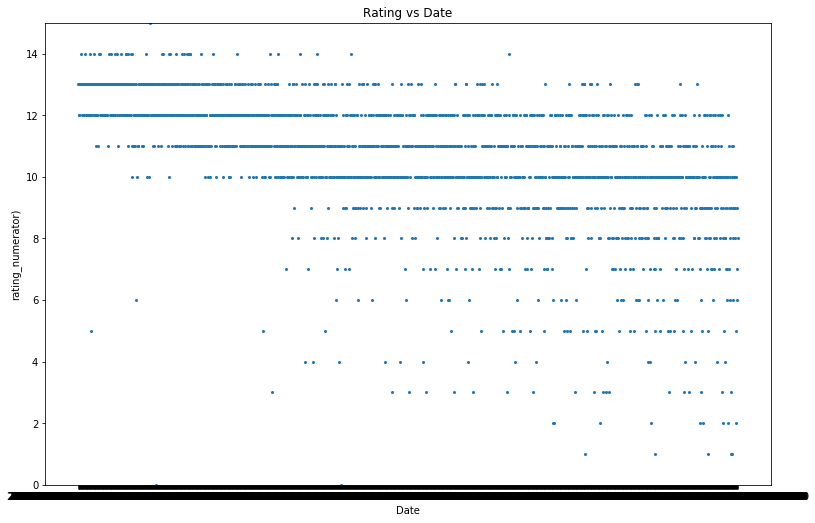

In [471]:
plt.figure(1, figsize = (13, 8.5))
plt.plot(df_archive.timestamp, df_archive.rating_numerator, marker='o', linestyle='', ms = 2)
plt.ylim(0,15)
plt.title('Rating vs Date')
plt.ylabel('rating_numerator)')
plt.xlabel('Date');
#plt.show()

In [468]:
#plt.hist(df_archive.rating_numerator);

#y = df_archive.groupby('rating_numerator').rating_numerator.mean() * 100
y = df_archive.groupby('rating_numerator').rating_numerator.count()
y
# plt.bar(y.index, y, color="blue")
# plt.title('# of Ratings')
# plt.xlabel('Rating')
# plt.ylabel('Count');

rating_numerator
0         2
1         5
2         9
3        19
4        16
5        34
6        32
7        52
8        95
9       151
10      428
11      413
12      473
13      276
14       38
15        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [449]:
string = ""
for i in high_numerators:
    index = int(df_archive.loc[i].text.find('/10'))
    #string += str(i) + ": '" + df_archive.loc[i].text[index-6:index+3] + "'\t\t" 
    string += str(i) + ": '" + df_archive.loc[i].text[index-6:index+3] + "'\n" 
print(string)

516: ''
902: ''
1433: ''
2074: 'g. 420/10'
1712: ' 11.26/10'
433: ''
1202: 'af. 11/10'
1843: ''
695: 'f 9.75/10'
1351: ''
1228: ''
979: '. 1776/10'
1120: ''
1634: ''
1635: ''
1254: ''
1779: ''
1274: ''
763: ' 11.27/10'



<span style="color:blue">
    
<span style="color:black"> Investigate / clean the following issues: </span>
* In **df_archive**, the maximum value for rating_numerator is unrealistically high.
* In **df_archive**, the maximum value for rating_denominator is unrealistically high.
* In **df_archive**, the minimum value for rating_numerator probably should not be zero.
* In **df_archive**, the minimum value for rating_denominator should not be zero.
</span>

<a id='code_snippets_merging'></a>
([Top of Page](#top_of_page))

<span style="color:red">

## Code Snippets for Later - Merging Dataframes
</span>

In [374]:
tweetsKeep = set(df_images_orig.tweet_id)
print('# of tweets to keep = ' + str(len(tweetsKeep)))

# df_archive = df_archive[df_archive.tweet_id.isin(df_images.tweet_id)]
# df_tweetInfo = df_tweetInfo[df_tweetInfo.tweet_id.isin(df_images.tweet_id)]
# len(df_tweetInfo)

numTweets_archive_and_images = len(df_archive[df_archive.tweet_id.isin(df_images.tweet_id)])
#numTweets_tweetInfo_and_images = len(df_tweetInfo[df_tweetInfo.tweet_id.isin(df_images.tweet_id)])

mask = df_tweetInfo.tweet_id.isin(df_images.tweet_id)
numTweets_tweetInfo_and_images = len(df_tweetInfo[mask])

tweetsKeep = df_tweetInfo[df_tweetInfo.tweet_id.isin(df_images.tweet_id)]

print('len(tweetInfo): ' + str(len(df_tweetInfo)))
print(numTweets_archive_and_images)
print(numTweets_tweetInfo_and_images)

# of tweets to keep = 2075
len(tweetInfo): 2335
2075
2063


In [401]:
df_archive = df_archive_orig.copy(deep=True)
df_images = df_images_orig.copy(deep=True)
df_tweetInfo = df_tweetInfo_orig.copy(deep=True)
print(len(df_archive))
print(len(df_images))
print(len(df_tweetInfo))

2356
2075
2335


Prior to joining the dataframes, check to make sure that they do not share column names.

In [402]:
print(df_archive.columns)
print('--------------------------------------------------------')
print(df_images.columns)
print('--------------------------------------------------------')
print(df_tweetInfo.columns)

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')
--------------------------------------------------------
Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')
--------------------------------------------------------
Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')


The only shared column name is 'tweet_id'. This will be the column that the dataframes are joined on.

Reference: StackOverflow post on [how to merge dataframes and avoid duplicating columns](https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns)

In [425]:
df_master = pd.merge(df_archive, df_images, how='inner', on='tweet_id')
cols_to_use = df_tweetInfo.columns.difference(df_master.columns)
print(cols_to_use)

df_master = pd.merge(df_master, df_tweetInfo[cols_to_use], left_index=True, right_index=True, how='inner')
print('---------------------------------------------------------------------')
print(df_master.columns)
print(len(df_master))

Index(['favorite_count', 'retweet_count'], dtype='object')
---------------------------------------------------------------------
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count'],
      dtype='object')
2075


In [398]:
df_new = pd.merge(df_archive, df_images, how='inner', on='tweet_id')
df_new2 = pd.merge(df_tweetInfo, df_images, how='inner', on='tweet_id')

cols_to_use = df_new2.columns.difference(df_new.columns)
print(cols_to_use)
#print(len(df_new))
#print(len(df_new2))
#df_new2 = pd.merge(df_tweetInfo, df_images, how='inner', on='tweet_id')
#df_new3 = pd.merge(df_new, df_new2[cols_to_use], how='outer', on='tweet_id')
df_new3 = pd.merge(df_new, df_new2[cols_to_use], left_index=True, right_index=True, how='outer')
print('---------------------------------------------------------------------')
print(df_new.columns)
print('---------------------------------------------------------------------')
print(df_new2.columns)
print('---------------------------------------------------------------------')
print(df_new3.columns)
#df_new2[cols_to_use]

2075
2063
Index(['favorite_count', 'retweet_count'], dtype='object')
---------------------------------------------------------------------
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')
---------------------------------------------------------------------
Index(['tweet_id', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')
---------------------------------------------------------------------
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
 

In [ ]:
df_new = pd.merge(df_archive, df_images, how='inner', on='tweet_id')
df_new2 = pd.merge(df_tweetInfo, df_images, how='inner', on='tweet_id')
df_new3 = pd.merge(df_new, df_new2, how='inner', on='tweet_id')
print(len(df_new))
print(len(df_new2))
print(len(df_new3))
#print(df_new3.columns)
df_new3.head()

#df_new = df_archive.join(df_images.set_index('tweet_id'),on='tweet_id',how='inner')
#df_new2 = df_tweetInfo.join(df_images.set_index('tweet_id'),on='tweet_id',how='inner')
#df_new.head()
#print(len(df_new))
#print(len(df_new2))

# df_new3 = df_new2.join(df_new.set_index('tweet_id'),on='tweet_id',how='inner')
# print(len(df_new3))

In [383]:
df_new = pd.merge(df_archive, df_images, how='inner', on='tweet_id')
df_new2 = pd.merge(df_tweetInfo, df_images, how='inner', on='tweet_id')
df_new3 = pd.merge(df_new, df_new2, how='inner', on='tweet_id')
print(len(df_new))
print(len(df_new2))
print(len(df_new3))
#print(df_new3.columns)
print(df_new3.columns)
df_new3.head()

#df_new = df_archive.join(df_images.set_index('tweet_id'),on='tweet_id',how='inner')
#df_new2 = df_tweetInfo.join(df_images.set_index('tweet_id'),on='tweet_id',how='inner')
#df_new.head()
#print(len(df_new))
#print(len(df_new2))

# df_new3 = df_new2.join(df_new.set_index('tweet_id'),on='tweet_id',how='inner')
# print(len(df_new3))

2075
2063
2063
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url_x', 'img_num_x', 'p1_x', 'p1_conf_x', 'p1_dog_x', 'p2_x',
       'p2_conf_x', 'p2_dog_x', 'p3_x', 'p3_conf_x', 'p3_dog_x',
       'retweet_count', 'favorite_count', 'jpg_url_y', 'img_num_y', 'p1_y',
       'p1_conf_y', 'p1_dog_y', 'p2_y', 'p2_conf_y', 'p2_dog_y', 'p3_y',
       'p3_conf_y', 'p3_dog_y'],
      dtype='object')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num_y,p1_y,p1_conf_y,p1_dog_y,p2_y,p2_conf_y,p2_dog_y,p3_y,p3_conf_y,p3_dog_y
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [339]:
df_archive = df_archive[df_archive.tweet_id.isin(df_images.tweet_id)]
len(df_archive)

2075

In [340]:
df_tweetInfo = df_tweetInfo[df_tweetInfo.tweet_id.isin(df_images.tweet_id)]
len(df_tweetInfo)

2063

In [ ]:
#df_tweetInfo

### Test:

<a id='clean_tidiness'></a>
([Top of Page](#top_of_page))
## Clean - Tidiness

<a id='open_items'></a>
([Top of Page](#top_of_page))

<span style="color:red">

## Open Items
</span>

<a id='open_items_to_check'></a>
([Top of Page](#top_of_page))

<span style="color:red">

### Issues to check for: 

* **Accuracy**
  * There maybe some entries that are not pictures of dogs (typically rated less than 10?)
  * Some names in the name columns can't possibly be dog names. (a, an, the, etc...)

* **Completeness**
  * Missing data for dog breed predictions:
  * Only want original ratings. Make sure we don't have retweets. 
</span>

<a id='open_items_prelimCode_doggo_accuracy'></a>
([Top of Page](#top_of_page))

<span style="color:red">

### Preliminary code to check accuracy of **doggo** column in df_archive
* This mini-analysis is incomplete, and probably needs revisited.

</span>

In [311]:
# determine how many entries have "doggo" in the tweet
df_temp = df_archive[df_archive['text'].str.contains("doggo")]
#df_temp.doggo.count()

# of those entries, determine how many have 'None' in the 'doggo' column
df_temp2 = df_temp[df_temp['doggo'].str.contains("None")]
#df_temp2.count()
#df_temp2.text[0:5].apply(lambda entry: print(entry))
df_temp2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None
268,841439858740625411,NaN,NaN,2017-03-14 00:04:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have some incredible doggos for #K9Vet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841439858...,14,10,None,None,None,None,None
302,836648853927522308,NaN,NaN,2017-02-28 18:46:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @SchafeBacon2016: @dog_rates Slightly distu...,8.366481e+17,7.124572e+17,2017-02-28 18:43:57 +0000,https://twitter.com/SchafeBacon2016/status/836...,11,10,None,None,None,None,None
475,816062466425819140,NaN,NaN,2017-01-02 23:23:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Jack. He's one of the rare...,8.159907e+17,4.196984e+09,2017-01-02 18:38:42 +0000,https://www.gofundme.com/surgeryforjacktheminp...,11,10,Jack,None,None,None,None
477,815990720817401858,NaN,NaN,2017-01-02 18:38:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jack. He's one of the rare doggos that do...,NaN,NaN,NaN,https://www.gofundme.com/surgeryforjacktheminp...,11,10,Jack,None,None,None,None


In [312]:
# ----- LEFTOVER CODE SNIPPETS -----
#f = lambda x: print(x)
#df_temp2.count()
#for row2 in df_temp2:
#    print(row2)
#df_temp3['doggo'] = df_temp2['doggo'].apply(lambda x: x > 0)
#df_temp2
#     # filter to all entries where the 'doggo' column == 'None'
#     # print
# df_temp = df_archive[df_archive['text'].str.contains("doggo")]
# #df_archive[df_archive['text'].str.contains("doggo")].count()
# #df_archive.groupby('doggo').count()
# df_archive.groupby('doggo').count()
# #df_temp.head()
# #df_temp[df]

#df_archive.groupby('rating_numerator').rating_numerator.count()
#df_archive[df_archive['text'].str.contains("doggo")]
#df_archive[df_archive['text'].str.contains("doggo")].iloc[2].text

<a id='open_items_to_be_aware_of'></a>
([Top of Page](#top_of_page))

<span style="color:purple">

## Issues to be aware of (don't necessarily have to correct): 

**Completeness**
  * Not all tweet ids in **df_archive** table have images<br><br>

**Validity**
  * Data have reply tweets in which rating is changed thus making two observations about same dog and also making the first rating obsolete
  
  
</span>